In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd '/content/drive/MyDrive/DataScience/plate_project_group09'

/content/drive/.shortcut-targets-by-id/1Vt0fOz_0sVJoPLSXwaaNYYz64X3oIxL9/DataScience/plate_project_group09


In [3]:
#plate_detector
import cv2
import numpy as np
from utils import decode_netout
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.models import Model
from losses import YoloLoss
from callbacks import MapEvaluation
import tensorflow as tf
from tensorflow.keras.models import load_model

class PlateDetector:
  def __init__(self):
      self.model = None
      self.anchors = [0.83010,1.00442, 1.23452,1.54667, 1.70144,2.04439, 2.04351,2.74348, 2.90889,3.59401]
      self.num_anchors = len(self.anchors)//2
      self.labels = ['license plates']
      self.num_classes = len(self.labels)
      self.batch_size = 16

      self.image_w = 500
      self.image_h = 500

  def save_model(self):
      pass  # delete this line and replace yours

  def load_model(self):
    self.model = load_model(
        'models/plate_best_map.hdf5',
        custom_objects={
          'yolo_loss': YoloLoss(anchors=self.anchors, grid_size=[14, 14], batch_size=self.batch_size, lambda_obj = 5.0)
        }
      )
      

  def predict(self, image):
      w = image.width
      h = image.height
      image = image.resize([self.image_w, self.image_h])
      image_np = np.array(image)
      preprocessed_image = np.array([self.preprocess_input(image_np)])
      netout = self.model.predict(preprocessed_image)[0]
      boxes = decode_netout(
          netout, self.anchors, self.num_classes, 0.5, 0.3)
      list_result = []
      for box in boxes:
          xmin = box.xmin * w
          ymin = box.ymin * h
          xmax = box.xmax * w
          ymax = box.ymax * h
          label = self.labels[box.label]
          list_result.append((xmin, ymin, xmax, ymax))
      return list_result

  def preprocess_input(self, image):
      return preprocess_input(image)

  def infer(self, image, iou_threshold=0.5, score_threshold=0.5):
      image = cv2.resize(image, (self.image_w, self.image_h))
      image = image[..., ::-1]  # make it RGB (it is important for normalization of some backends)

      image = self.preprocess_input(image)
      if len(image.shape) == 3:
          input_image = image[np.newaxis, :]
      else:
          input_image = image[np.newaxis, ..., np.newaxis]

      netout = self.model.predict(input_image)[0]

      boxes = decode_netout(netout, self.anchors, self.num_classes, score_threshold, iou_threshold)

      return boxes


In [5]:
#char detector
import cv2
import numpy as np
from utils import decode_netout
from tensorflow.keras.applications.inception_v3 import preprocess_input
from losses import YoloLoss
from tensorflow.keras.models import load_model

class CharacterDetector:
  def __init__(self):
      self.model = None
      self.anchors = [2.14354,7.09621, 2.27289,4.57841, 3.04554,6.47130, 3.72244,6.75562, 4.04422,7.65468]
      self.num_anchors = len(self.anchors)//2
      self.labels = ['char']
      self.num_classes = len(self.labels)
      self.batch_size = 16

      self.image_w = 300
      self.image_h = 300

  def save_model(self):
      pass  # delete this line and replace yours

  def load_model(self):
    self.model = load_model(
        'models/character1_best_map.hdf5',
        custom_objects={
          'yolo_loss': YoloLoss(anchors=self.anchors, grid_size=[9,9], batch_size=self.batch_size, lambda_obj = 5.0)
        }
      )

  def predict(self, image):
      w = image.width
      h = image.height
      image = image.resize([self.image_w, self.image_h])
      image_np = np.array(image)
      preprocessed_image = np.array([self.preprocess_input(image_np)])
      netout = self.model.predict(preprocessed_image)[0]
      boxes = decode_netout(
          netout, self.anchors, self.num_classes, 0.5, 0.5)
      list_result = []
      for box in boxes:
          xmin = box.xmin * w
          ymin = box.ymin * h
          xmax = box.xmax * w
          ymax = box.ymax * h
          label = self.labels[box.label]
          list_result.append([xmin, ymin, xmax, ymax])
      return list_result

  def preprocess_input(self, image):
      return preprocess_input(image)

  def infer(self, image, iou_threshold=0.5, score_threshold=0.5):
      image = cv2.resize(image, (self.image_w, self.image_h))
      image = image[..., ::-1]  # make it RGB (it is important for normalization of some backends)

      image = self.preprocess_input(image)
      if len(image.shape) == 3:
          input_image = image[np.newaxis, :]
      else:
          input_image = image[np.newaxis, ..., np.newaxis]

      netout = self.model.predict(input_image)[0]

      boxes = decode_netout(netout, self.anchors, self.num_classes, score_threshold, iou_threshold)

      return boxes


In [7]:
#char classifier
from tensorflow.keras.models import load_model

class CharacterClassifier:
  def __init__(self):
    self.labels = [str(idx) for idx in range(10)] + [chr(idx) for idx in range(65, 65+26)]
    self.label_map = {label: idx for idx, label in enumerate(self.labels)}

  def load_model(self):
    self.model = load_model('models/char_classifier.h5')

  def predict(self, image):
    resized_image = np.array(image.resize([48,48]))
    output = self.model.predict(np.array([resized_image]))[0]
    label = self.labels[np.argmax(output)]
    return label

In [8]:
#plate_reader.py
# from plate_detector import PlateDetector
# from char_detector import CharacterDetector
# from char_classifier import CharacterClassifier
from PIL import Image, ImageDraw, ImageOps
import functools

def compare_bbox(b1, b2):
  center_x_1 = (b1[2] + b1[0]) / 2
  center_y_1 = (b1[3] + b1[1]) / 2
  center_x_2 = (b2[2] + b2[0]) / 2
  center_y_2 = (b2[3] + b2[1]) / 2

  dx = center_x_1 - center_x_2
  dy = center_y_1 - center_y_2
  if abs(dx) < abs(dy):
    return dy < 0
  return dx < 0

class PlateReader:
    def __init__(self):
        self.plate_detector = PlateDetector()
        self.char_detector = CharacterDetector()
        self.char_classifier = CharacterClassifier()

    def load_models(self):
      self.plate_detector.load_model()
      self.char_detector.load_model()
      self.char_classifier.load_model()

    def detect_plates(self, image):
        return self.plate_detector.predict(image)

    def read_plates(self, image):
        """
        :param image: a PIL Image object
        :return: a list of plate numbers
        """
        list_plate_bboxes = self.detect_plates(image)
        list_plate_number = []
        canvas = ImageDraw.Draw(image)
        for plate_bbox in list_plate_bboxes:
          plate_width = plate_bbox[2] - plate_bbox[0]
          plate_height = plate_bbox[3] - plate_bbox[1]
          plate_image = image.crop([
            plate_bbox[0] - 0.1 * plate_width,
            plate_bbox[1] - 0.1 * plate_height,
            plate_bbox[2] + 0.1 * plate_width,
            plate_bbox[3] + 0.1 * plate_height
          ])
          if plate_image.width < plate_image.height:
            plate_image = ImageOps.expand(plate_image, (0, 0 , plate_image.height - plate_image.width, 0))
          else:
            plate_image = ImageOps.expand(plate_image, (0, 0, 0, plate_image.width - plate_image.height))
          list_char_bboxes = self.char_detector.predict(plate_image)
          list_char_bboxes = sorted(list_char_bboxes, key=functools.cmp_to_key(compare_bbox))
          canvas = ImageDraw.Draw(plate_image)
          plate_number = ''
          for char_bbox in list_char_bboxes:
            char_image = plate_image.crop(char_bbox)
            char_label = self.char_classifier.predict(char_image)
            plate_number += char_label
            canvas.rectangle(char_bbox, outline='red')

          list_plate_number.append(plate_number)
          display(plate_image)
          print(plate_number)

        return list_plate_number



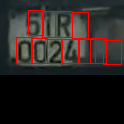

51B10024140


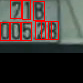

71B218005


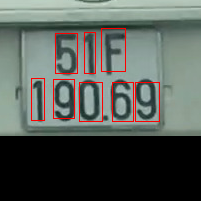

F5119069


['51B10024140', '71B218005', 'F5119069']

In [10]:
reader = PlateReader()
reader.load_models()
test_img = Image.open('/content/drive/MyDrive/DataScience/plate_project_group09/k2-f008053.jpg')
reader.read_plates(test_img)